In [1]:
import sys
import os
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from global_import import *
from valuation.val import perform_valuation

In [2]:
data = pd.read_csv(f'{DATA_FOLDER}/lagged_comp-fundr-ibes_for_val_1976-2019.csv', index_col = 0)
crsp = pd.read_csv(f'{DATA_FOLDER}/crsp_1959-2019.csv', index_col=0)
beta = pd.read_csv(f'{DATA_FOLDER}/capm_beta_weekly_1-3y_1959-2019.csv', index_col=0)

/Users/mmw/Installations/venvs/mlval/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/mmw/Installations/venvs/mlval/lib/python3.7/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [3]:
data = data.replace([np.inf, -np.inf], np.nan)
data = data.drop_duplicates(subset=['jdate', 'permno'])

<AxesSubplot:>

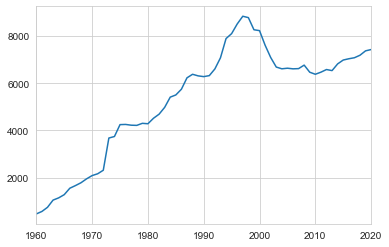

In [4]:
data['year'].value_counts().sort_index().plot()

In [7]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import r2_score
from datetime import datetime
from copy import deepcopy

mdfs={}

for year in range(1960, 1999):
    regr_dict = {}
    for pred_yr in [1,2,3,4,5]:
        tr = data.loc[(year <= data['year']) & (data['year'] <= year+19)]
        tryr = tr.dropna(subset = [f'epspx_{pred_yr}'])
        X_tr = tryr.drop(['ticker', 'exchcd', 'permno','jdate','year','epspx_1', 'epspx_2', 'epspx_3','epspx_4','epspx_5'], axis = 1)
        X_tr = X_tr.fillna(0).astype(float)
        y_tr = tryr[f'epspx_{pred_yr}']
        y_tr = y_tr.astype(float)
        pls_yr = PLSRegression(n_components = 10, )
        pls_yr.fit(X_tr, y_tr)
        regr_dict[pred_yr] = deepcopy(pls_yr)
        print(datetime.now(),year, pred_yr, 'IS R2', r2_score(y_tr, pls_yr.predict(X_tr)), X_tr.shape)
        
    ts = data.loc[(year+20 == data['year'])]
    X_ts = ts.drop(['ticker', 'exchcd', 'permno','jdate','year','epspx_1', 'epspx_2', 'epspx_3','epspx_4','epspx_5'], axis = 1)
    X_ts = X_ts.fillna(0).astype(float)
    
    y_pred_dict = {}
    for pred_yr in [1,2,3,4,5]:
        y_ts = ts[f'epspx_{pred_yr}'].fillna(0).astype(float)
        y_pred_dict[pred_yr] = regr_dict[pred_yr].predict(X_ts)
        try:
            print(datetime.now(), year+20, pred_yr, 'OOS R2', \
                 r2_score(y_ts[ts[f'epspx_{pred_yr}']>=1], 
                          y_pred_dict[pred_yr][ts[f'epspx_{pred_yr}']>=1]),
                 y_ts.shape, y_ts[ts[f'epspx_{pred_yr}']>=1].shape)
        except:
            print('no')
        
    mdf_rf = ts[['ticker', 'permno', 'exchcd', 'year', 'jdate', 'be']].copy()
    for pred_yr in [1,2,3,4,5]:
        mdf_rf[f'epspx_{pred_yr}'] =  y_pred_dict[pred_yr]
    for i in range(6,11):
        mdf_rf[f'epspx_{i}'] =  y_pred_dict[5]
    mdfs[year+20] = deepcopy(mdf_rf)

2020-11-02 17:07:12.230767 1960 1 IS R2 0.5800036970004046 (45798, 250)
2020-11-02 17:07:13.394771 1960 2 IS R2 0.44032693779888843 (44420, 250)
2020-11-02 17:07:14.504732 1960 3 IS R2 0.36683663312659764 (42940, 250)
2020-11-02 17:07:15.541707 1960 4 IS R2 0.30809673640888546 (41416, 250)
2020-11-02 17:07:16.577970 1960 5 IS R2 0.37487892468702544 (39819, 250)
2020-11-02 17:07:16.655741 1980 1 OOS R2 -15.748122593796317 (4283,) (2465,)
2020-11-02 17:07:16.664649 1980 2 OOS R2 -4.231853570672429 (4283,) (2335,)
2020-11-02 17:07:16.673043 1980 3 OOS R2 -5.7660709963604395 (4283,) (2027,)
2020-11-02 17:07:16.681213 1980 4 OOS R2 0.00109929838051126 (4283,) (2005,)
2020-11-02 17:07:16.689915 1980 5 OOS R2 0.546803069459479 (4283,) (1973,)
2020-11-02 17:07:17.985593 1961 1 IS R2 0.5855962452951813 (49357, 250)
2020-11-02 17:07:19.173450 1961 2 IS R2 0.43273473979417487 (47750, 250)
2020-11-02 17:07:20.325693 1961 3 IS R2 0.33949482540310405 (46062, 250)
2020-11-02 17:07:21.561586 1961 4 IS

KeyboardInterrupt: 

In [7]:
mdf_rf = pd.concat(mdfs.values())

In [8]:
mdf_rf = mdf_rf.sort_values(by=['permno', 'jdate'])

In [9]:
mdf_rf[mdf_rf.ticker=='TSLA']

,ticker,permno,exchcd,year,jdate,be,ni_1,ni_2,ni_3,ni_4,ni_5,ni_6,ni_7,ni_8,ni_9,ni_10
692395,TSLA,93436,3.0,2010,2010-06-30,NaN,-32.100272,-6.217449,16.498280,9.419305,27.552852,27.552852,27.552852,27.552852,27.552852,27.552852
692392,TSLA,93436,3.0,2011,2011-06-30,207.048,-141.545181,-96.244680,37.062505,44.765133,34.110959,34.110959,34.110959,34.110959,34.110959,34.110959
692389,TSLA,93436,3.0,2012,2012-06-30,224.045,-77.477716,49.117177,105.242599,94.826290,172.051797,172.051797,172.051797,172.051797,172.051797,172.051797
692386,TSLA,93436,3.0,2013,2013-06-30,124.700,80.569659,241.943790,325.810098,602.740781,581.177794,581.177794,581.177794,581.177794,581.177794,581.177794
692383,TSLA,93436,3.0,2014,2014-06-30,673.941,71.519202,205.316125,253.385858,116.611919,256.861467,256.861467,256.861467,256.861467,256.861467,256.861467
692380,TSLA,93436,3.0,2015,2015-06-30,969.906,-9.724401,169.740788,207.282819,351.985326,458.320426,458.320426,458.320426,458.320426,458.320426,458.320426
692377,TSLA,93436,3.0,2016,2016-06-30,1130.989,-102.429174,308.994237,859.536404,1210.262375,1284.232726,1284.232726,1284.232726,1284.232726,1284.232726,1284.232726
692374,TSLA,93436,3.0,2017,2017-06-30,4761.695,-313.868299,107.415766,743.894948,987.792274,1805.878532,1805.878532,1805.878532,1805.878532,1805.878532,1805.878532
692371,TSLA,93436,3.0,2018,2018-06-30,4237.312,-1531.170307,-806.339517,-427.528955,-229.487115,-90.346528,-90.346528,-90.346528,-90.346528,-90.346528,-90.346528


In [10]:
comp = mdf_rf
comp['jdate'] = pd.to_datetime(comp['jdate'])
comp.permno = comp.permno.astype(int)

beta['date']=pd.to_datetime(beta['DATE'].astype(str))
beta['jdate']=beta['date']+MonthEnd(0)
beta['permno'] = beta.index
beta = beta.drop_duplicates(subset=['permno', 'jdate'])

In [11]:
FF = pd.read_csv(f'{PROJECT_FOLDER}/lookup_tables/FF3.csv')
FF['date'] = FF['Unnamed: 0']
FF['date'] = pd.to_datetime(FF['date'].astype(str), format='%Y%m%d')
FF['jdate'] = FF['date']+MonthEnd(0)
FF = FF[['jdate', 'date', 'RF']]
FF['RF'] = (1+FF['RF']/100).pow(365)-1

beta = beta.merge(FF[['jdate', 'RF']],  on=['jdate'])
beta = beta.drop_duplicates(subset=['permno', 'jdate'])

In [12]:
comp.sort_values(['permno','jdate'], ascending = [True,True], inplace=True)
crsp['logret'] = np.log(1+crsp['retadj'])
crsp['termlogret'] = crsp.groupby('permno')['logret'].transform('sum') - crsp.groupby('permno')['logret'].transform('cumsum') + np.log(1-0.35) 
crsp['termcumret'] = np.exp(crsp['termlogret'])-1
crsp1 = crsp.copy()

/Users/mmw/Installations/venvs/mlval/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


In [13]:
for x in ['logret_3', 'logret_6', 'logret_12', 'logret_24', 
      'logret_36', 'logret_48', 'logret_60']:
    crsp1.loc[crsp1[x].isnull(), x] = crsp1['termlogret']


for x in ['cumret_3', 'cumret_6', 'cumret_12', 'cumret_24', 
      'cumret_36', 'cumret_48', 'cumret_60']:
    crsp1.loc[crsp1[x].isnull(), x] = crsp1['termcumret']

In [14]:
valdf = comp.merge(beta, on=['jdate', 'permno'])
valdf = perform_valuation(valdf, n=5, rp=0.07, tg=0.05)
valdf = valdf[['permno', 'year', 'PV', 'be']]
valdf.year = valdf.year + 1
val_crsp_mdf = valdf.merge(crsp1, on=['year', 'permno'])
val_crsp_mdf['vt'] = val_crsp_mdf['PV']*1000
val_crsp_mdf['be'] = val_crsp_mdf['be']*1000

In [26]:
val_df1 = val_crsp_mdf[['permno', 'ticker',  'exchcd', 'year', 'jdate', 'exchcd',
                        'vt','me', 'be', 'prc',
                        'logret_3', 'logret_6', 'logret_24', 'cumret_3', 'cumret_6', 'cumret_24',
                        'logret_12', 'logret_36', 'logret_48', 'logret_60', 
                        'cumret_12', 'cumret_36', 'cumret_48', 'cumret_60',]]
val_df1.sort_values(['permno','jdate'], ascending = [True,False], inplace=True)

/Users/mmw/Installations/venvs/mlval/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [27]:
val_df2 = val_df1.copy()
for m in [3, 6, 12, 24, 36, 48, 60]:
    val_df2[f'vt+{m}'] = val_df1.groupby('permno')['vt'].shift(m)
    val_df2[f'me+{m}'] = val_df1.groupby('permno')['me'].shift(m)
    val_df2[f'be+{m}'] = val_df1.groupby('permno')['be'].shift(m)

In [28]:
val_df3 = val_df2.copy()
for m in [3, 6, 12, 24, 36, 48, 60]:
    val_df3['vt'] = np.log(val_df2.vt)
    val_df3[f'vt+{m}'] = np.log(val_df2[f'vt+{m}'].astype(float))
    val_df3['me'] = np.log(val_df2['me'].astype(float))
    val_df3[f'me+{m}'] = np.log(val_df2[f'me+{m}'].astype(float))
    val_df3[f'r_t+{m}'] = val_df3[f'logret_{m}']
    val_df3[f'r*_t+{m}'] = val_df3[f'vt+{m}'] -  val_df3[f'vt']
    val_df3[f'r_unchg+{m}'] = - (1-0.975) * (val_df3['me'] -  val_df3['vt'])
    val_df3[f'r_chg+{m}'] = 0.975 * ( (val_df3[f'me+{m}'] -  val_df3[f'vt+{m}']) - ((val_df3[f'me'] -  val_df3['vt'])) )
    

/Users/mmw/Installations/venvs/mlval/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/mmw/Installations/venvs/mlval/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.
/Users/mmw/Installations/venvs/mlval/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
/Users/mmw/Installations/venvs/mlval/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


In [29]:
val_df3 = val_df3[(val_df3.year >=1980) & (val_df3.year<=2020)]
val_df3 = val_df3.drop_duplicates(subset=['permno', 'jdate'])

In [30]:
val_df3['misp'] = val_df3['me'] - val_df3['vt']
# val_df3 = val_df3.dropna(subset=['misp', 'r_t+60'])
val_df3 = val_df3.replace([np.inf, -np.inf], np.nan)

In [31]:
val_df3[(val_df3.ticker=='WMT') ]

,permno,ticker,exchcd,year,jdate,exchcd,vt,me,be,prc,logret_3,logret_6,logret_24,cumret_3,cumret_6,cumret_24,logret_12,logret_36,logret_48,logret_60,cumret_12,cumret_36,cumret_48,cumret_60,vt+3,me+3,be+3,vt+6,me+6,be+6,vt+12,me+12,be+12,vt+24,me+24,be+24,vt+36,me+36,be+36,vt+48,me+48,be+48,vt+60,me+60,be+60,r_t+3,r*_t+3,r_unchg+3,r_chg+3,r_t+6,r*_t+6,r_unchg+6,r_chg+6,r_t+12,r*_t+12,r_unchg+12,r_chg+12,r_t+24,r*_t+24,r_unchg+24,r_chg+24,r_t+36,r*_t+36,r_unchg+36,r_chg+36,r_t+48,r*_t+48,r_unchg+48,r_chg+48,r_t+60,r*_t+60,r_unchg+60,r_chg+60,misp
733803,55976,WMT,1,2019,2019-12-31,1,21.424806,19.636097,82131000.0,118.839996,-0.430783,-0.430783,-0.430783,-0.350000,-0.350000,-0.350000,-0.430783,-0.430783,-0.430783,-0.430783,-0.350000,-0.350000,-0.350000,-0.350000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.430783,NaN,0.044718,NaN,-0.430783,NaN,0.044718,NaN,-0.430783,NaN,0.044718,NaN,-0.430783,NaN,0.044718,NaN,-0.430783,NaN,0.044718,NaN,-0.430783,NaN,0.044718,NaN,-0.430783,NaN,0.044718,NaN,-1.788708
733802,55976,WMT,1,2019,2019-11-30,1,21.424806,19.640701,82131000.0,119.089996,-0.428435,-0.428435,-0.428435,-0.348472,-0.348472,-0.348472,-0.428435,-0.428435,-0.428435,-0.428435,-0.348472,-0.348472,-0.348472,-0.348472,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.428435,NaN,0.044603,NaN,-0.428435,NaN,0.044603,NaN,-0.428435,NaN,0.044603,NaN,-0.428435,NaN,0.044603,NaN,-0.428435,NaN,0.044603,NaN,-0.428435,NaN,0.044603,NaN,-0.428435,NaN,0.044603,NaN,-1.784104
733801,55976,WMT,1,2019,2019-10-31,1,21.424806,19.625216,82131000.0,117.260002,-0.412949,-0.412949,-0.412949,-0.338304,-0.338304,-0.338304,-0.412949,-0.412949,-0.412949,-0.412949,-0.338304,-0.338304,-0.338304,-0.338304,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.412949,NaN,0.044990,NaN,-0.412949,NaN,0.044990,NaN,-0.412949,NaN,0.044990,NaN,-0.412949,NaN,0.044990,NaN,-0.412949,NaN,0.044990,NaN,-0.412949,NaN,0.044990,NaN,-0.412949,NaN,0.044990,NaN,-1.799590
733800,55976,WMT,1,2019,2019-09-30,1,21.424806,19.637253,82131000.0,118.680000,0.005797,-0.424986,-0.424986,0.005814,-0.346221,-0.346221,-0.424986,-0.424986,-0.424986,-0.424986,-0.346221,-0.346221,-0.346221,-0.346221,21.424806,19.636097,82131000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.005797,0.000000,0.044689,-0.001126,-0.424986,NaN,0.044689,NaN,-0.424986,NaN,0.044689,NaN,-0.424986,NaN,0.044689,NaN,-0.424986,NaN,0.044689,NaN,-0.424986,NaN,0.044689,NaN,-0.424986,NaN,0.044689,NaN,-1.787553
733799,55976,WMT,1,2019,2019-08-31,1,21.424806,19.602962,82131000.0,114.260002,0.041403,-0.387032,-0.387032,0.042272,-0.320930,-0.320930,-0.387032,-0.387032,-0.387032,-0.387032,-0.320930,-0.320930,-0.320930,-0.320930,21.424806,19.640701,82131000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.041403,0.000000,0.045546,0.036796,-0.387032,NaN,0.045546,NaN,-0.387032,NaN,0.045546,NaN,-0.387032,NaN,0.045546,NaN,-0.387032,NaN,0.045546,NaN,-0.387032,NaN,0.045546,NaN,-0.387032,NaN,0.045546,NaN,-1.821844
733798,55976,WMT,1,2019,2019-07-31,1,21.424806,19.568414,82131000.0,110.379997,0.065093,-0.347856,-0.347856,0.067258,-0.293800,-0.293800,-0.347856,-0.347856,-0.347856,-0.347856,-0.293800,-0.293800,-0.293800,-0.293800,21.424806,19.625216,82131000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.065093,0.000000,0.046410,0.055382,-0.347856,NaN,0.046410,NaN,-0.347856,NaN,0.046410,NaN,-0.347856,NaN,0.046410,NaN,-0.347856,NaN,0.046410,NaN,-0.347856,NaN,0.046410,NaN,-0.347856,NaN,0.046410,NaN,-1.856392
733797,55976,WMT,1,2019,2019-06-30,1,21.424806,19.569410,82131000.0,110.489998,0.076134,0.081931,-0.348852,0.079107,0.085381,-0.294503,-0.348852,-0.348852,-0.348852,-0.348852,-0.294503,-0.294503,-0.294503,-0.294503,21.424806,19.637253,82131000.0,21.424806,19.636097,82131000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.076134,0.000000,0.0

In [41]:
val_df3 = val_df3.replace([np.inf, -np.inf], np.nan)
val_df3.to_csv(f'{DATA_FOLDER}/decomp_dcf5y_PLS_rolling_1980_2019.csv')

In [42]:
val_df3.describe()

,permno,exchcd,year,exchcd,vt,me,be,prc,logret_3,logret_6,logret_24,cumret_3,cumret_6,cumret_24,logret_12,logret_36,logret_48,logret_60,cumret_12,cumret_36,cumret_48,cumret_60,vt+3,me+3,be+3,vt+6,me+6,be+6,vt+12,me+12,be+12,vt+24,me+24,be+24,vt+36,me+36,be+36,vt+48,me+48,be+48,vt+60,me+60,be+60,r_t+3,r*_t+3,r_unchg+3,r_chg+3,r_t+6,r*_t+6,r_unchg+6,r_chg+6,r_t+12,r*_t+12,r_unchg+12,r_chg+12,r_t+24,r*_t+24,r_unchg+24,r_chg+24,r_t+36,r*_t+36,r_unchg+36,r_chg+36,r_t+48,r*_t+48,r_unchg+48,r_chg+48,r_t+60,r*_t+60,r_unchg+60,r_chg+60,misp
count,1.285973e+06,1.285973e+06,1.285973e+06,1.285973e+06,1.285973e+06,1.285503e+06,1.185924e+06,1.285503e+06,1.285961e+06,1.285951e+06,1.285905e+06,1.285973e+06,1.285973e+06,1.285973e+06,1.285937e+06,1.285869e+06,1.285833e+06,1.285807e+06,1.285973e+06,1.285973e+06,1.285973e+06,1.285973e+06,1.214201e+06,1.255993e+06,1.158904e+06,1.143957e+06,1.227075e+06,1.132429e+06,1.008109e+06,1.171057e+06,1.081142e+06,874708.000000,1.068342e+06,9.862580e+05,774341.000000,975489.000000,9.002730e+05,699137.000000,891253.000000,8.225600e+05,636624.000000,814524.000000,7.522190e+05,1.285961e+06,1.214201e+06,1.285503e+06,1.213560e+06,1.285951e+06,1.143957e+06,1.285503e+06,1.143391e+06,1.285937e+06,1.008109e+06,1.285503e+06,1.007691e+06,1.285905e+06,874708.000000,1.285503e+06,874313.000000,1.285869e+06,774341.000000,1.285503e+06,773964.000000,1.285833e+06,699137.000000,1.285503e+06,698805.000000,1.285807e+06,636624.000000,1.285503e+06,636381.000000,1.285503e+06
mean,5.665707e+04,1.958815e+00,1.999800e+03,1.958815e+00,1.371424e+01,1.261066e+01,2.005171e+06,3.707855e+01,-3.995988e-03,-8.272790e-03,-1.639381e-02,2.591141e-02,5.138991e-02,2.204081e-01,-1.213182e-02,-2.606927e-02,-3.045062e-02,-3.442997e-02,1.079563e-01,3.148826e-01,4.188172e-01,5.248301e-01,1.375464e+01,1.263125e+01,2.032508e+06,1.379902e+01,1.265144e+01,2.060522e+06,1.390117e+01,1.269654e+01,2.117885e+06,14.008361,1.278972e+01,2.237032e+06,14.101415,12.876601,2.369135e+06,14.182161,12.969697,2.514765e+06,14.273899,13.062501,2.680267e+06,-3.995988e-03,1.556811e-02,2.761002e-02,-7.888659e-03,-8.272790e-03,3.283477e-02,2.761002e-02,-1.689899e-02,-1.213182e-02,7.332315e-02,2.761002e-02,-2.911201e-02,-1.639381e-02,0.195834,2.761002e-02,-0.075240,-2.606927e-02,0.315145,2.761002e-02,-0.115775,-3.045062e-02,0.440474,2.761002e-02,-0.160051,-3.442997e-02,0.574926,2.761002e-02,-0.219923,-1.104401e+00
std,2.610541e+04,9.490082e-01,1.086830e+01,9.490082e-01,2.055940e+00,2.312955e+00,9.194059e+06,9.411090e+02,2.480255e-01,3.541590e-01,7.239282e-01,2.727192e-01,4.052066e-01,1.303077e+00,5.085793e-01,8.776610e-01,1.005827e+00,1.114817e+00,6.410412e-01,1.681384e+00,2.203019e+00,1.958457e+00,2.045881e+00,2.311509e+00,9.250285e+06,2.033711e+00,2.310464e+00,9.306885e+06,2.001119e+00,2.305477e+00,9.420038e+06,2.000214,2.296124e+00,9.618691e+06,2.003037,2.297552,9.815490e+06,2.002390,2.300671,1.015276e+07,2.001554,2.304024,1.059327e+07,2.480255e-01,4.976992e-01,4.864263e-02,5.454181e-01,3.541590e-01,7.212614e-01,4.864263e-02,7.845644e-01,5.085793e-01,1.074519e+00,4.864263e-02,1.145711e+00,7.239282e-01,1.285546,4.864263e-02,1.382068,8.776610e-01,1.394994,4.864263e-02,1.500720,1.005827e+00,1.455894,4.864263e-02,1.572909,1.114817e+00,1.461165,4.864263e-02,1.592468,1.945705e+00
min,1.000100e+04,1.000000e+00,1.981000e+03,1.000000e+00,2.562387e+00,2.617396e+00,1.000000e+00,1.540000e-02,-9.478570e+00,-9.780850e+00,-1.484859e+01,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.225534e+01,-1.652222e+01,-1.874448e+01,-1.874448e+01,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,2.562387e+00,2.617396e+00,1.000000e+00,2.562387e+00,2.617396e+00,1.000000e+00,2.562387e+00,3.421817e+00,1.000000e+00,4.145434,1.571217e+00,1.000000e+00,4.271774,1.424613,1.000000e+00,4.271774,1.313388,1.000000e+00,4.271774,1.963610,1.000000e+00,-9.478570e+00,-3.126221e+01,-2.662315e-01,-2.865985e+01,-9.780850e+00,-3.126221e+01,-2.662315e-01,-2.875278e+01,-1.225534e+01,-3.126221e+01,-2.662315e-01,-2.876178e+0

In [40]:
val_df3.me.quantile(0.4)

12.000351439907833